

# Import libraries.


In [ ]:
#Importing the basic required librarires

import math
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [ ]:
#Defining some variables

random_seed=123
batch_size = 64
img_height = 224
img_width = 224

In [ ]:
#importing tensorflow dataset
import tensorflow_datasets as tfds

#fetching the dataset
builder = tfds.builder('cats_vs_dogs')
info = builder.info

In [ ]:
# defining  the Class label
class_names = builder.info.features['label'].names
class_names

['cat', 'dog']

In [ ]:
# Loading the cats vs dogs dataset

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserving 10% for validation and 10% for test
    split=["train[:80%]", "train[80%:90%]", "train[90%:100%]"],
    as_supervised=True,  
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


2022-05-06 11:35:50.627669: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
# defining Shape for the image
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(262, 350, 3)
1


2022-05-06 11:35:50.853408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(
[[[242 248 248]
  [240 246 246]
  [235 239 238]
  ...
  [188 174 127]
  [145 133  85]
  [161 149 101]]

 [[238 244 244]
  [239 245 245]
  [235 239 238]
  ...
  [188 176 128]
  [165 153 105]
  [178 168 119]]

 [[237 241 240]
  [238 242 241]
  [232 236 235]
  ...
  [200 187 142]
  [201 191 142]
  [200 192 143]]

 ...

 [[130 122  75]
  [152 146  98]
  [154 148  98]
  ...
  [161 166 136]
  [ 77  86  57]
  [ 71  82  52]]

 [[167 159 112]
  [105  99  51]
  [148 142  92]
  ...
  [ 67  73  45]
  [ 46  56  29]
  [ 41  54  26]]

 [[138 130  83]
  [ 83  77  29]
  [135 129  79]
  ...
  [ 68  74  46]
  [ 14  27   1]
  [ 63  77  51]]], shape=(262, 350, 3), dtype=uint8)


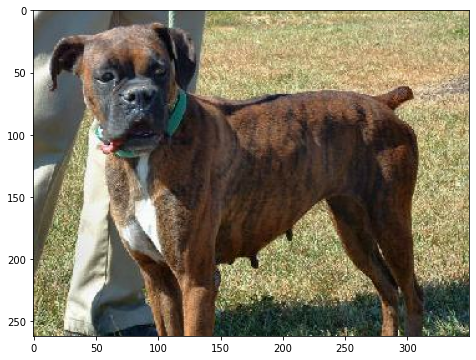

In [ ]:
# sampling images

image, label = next((iter(train_ds)))
print(label)
print(image)
plt.imshow(image.numpy().astype("uint8"))

# Data processing and visualization

---



In [ ]:
# defining functions for resizing the data
def resize(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [img_height, img_width])
  return image, label


 # defining functions for rescaling the data
def rescale(image, label):
  image = (image / 255.0)
  return image, label


# functions for augmenting the data
def img_augment(image, label):
    
    # Use tensorflow addons to randomly rotate images
    deg = np.random.uniform(-20,20)
    image = tfa.image.rotate(image, deg)
    

    # Random left right flip (Randomly flip an image horizontally (left to right))
    image = tf.image.random_flip_left_right(image)
    
    #Random fil up down (Randomly flips an image vertically (upside down))
    image = tf.image.stateless_random_flip_up_down(image, seed = (0,1))
    
    return image, label


In [ ]:
#definig the functions for Preprocessing the Dataset

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).map(resize).map(rescale).map(img_augment).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().shuffle(1000).map(resize).map(rescale).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(resize).batch(batch_size)

In [ ]:
# shape of image after processing

for image_batch, labels_batch in test_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 224, 224, 3)
[0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1]


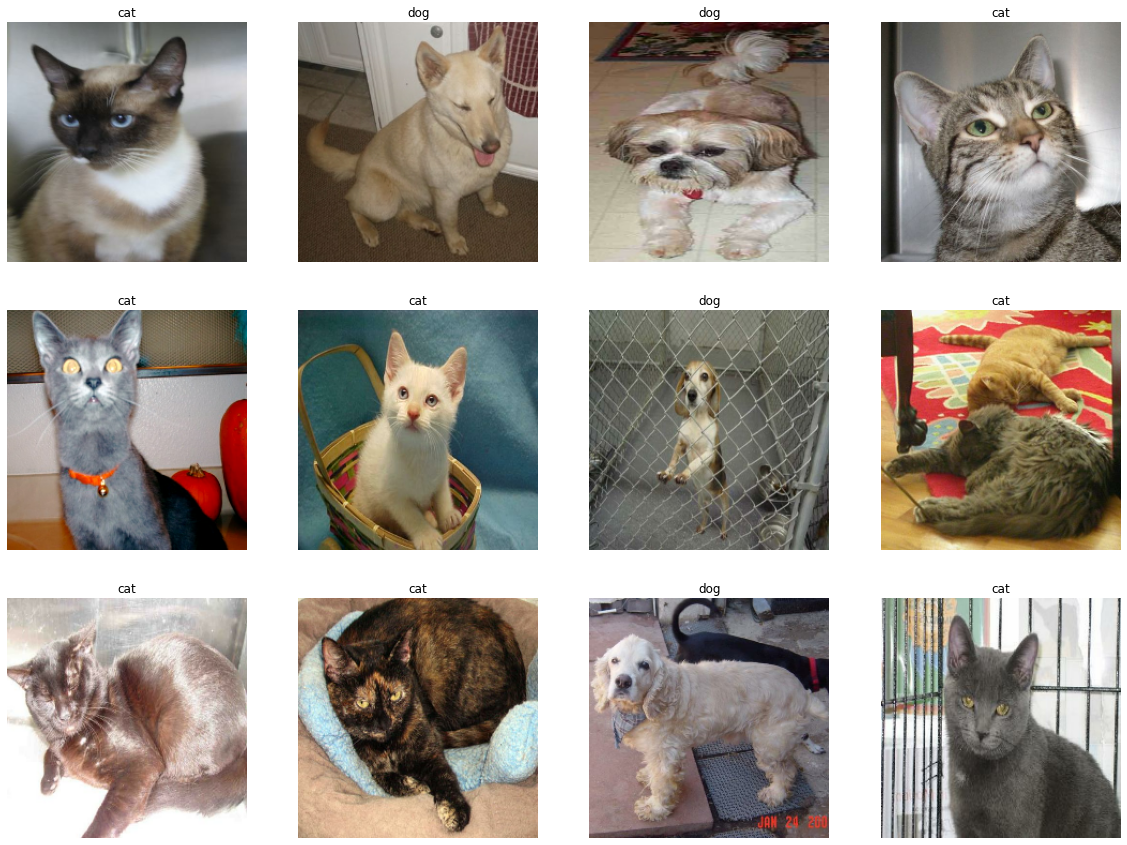

In [ ]:
# Visualization of the data from test split

plt.figure(figsize=(20, 15))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# function for plotting of the model history

def perf_plot(history):
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  

  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

  ax[0].set_title('Training Accuracy vs. Epochs')
  ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
  ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(loc='best')

  ax[1].set_title('Training/Validation Loss vs. Epochs')
  ax[1].plot(train_loss, 'o-', label='Train Loss')
  ax[1].plot(val_loss, 'o-', label='Validation Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(loc='best')


  plt.tight_layout()
  plt.show()

In [ ]:
# Function for visualization of the predicted result

def prediction(model, test):
  for image_batch, labels_batch in test.take(1):
    for images, labels in test_ds.take(1):
        plt.figure(figsize=(20, 30))
        for i in range(24):
          ax = plt.subplot(6, 4, i + 1)
          image = images[i].numpy().astype('uint8')
          label = labels[i].numpy()
          
         
          plt.imshow(image)
          Actual_label = (class_names[label])
          pred = model.predict(image_batch)
          Predicted_label = class_names[np.argmax(pred[i])]
          plt.title(f"Actual: {Actual_label}, \nPredicted: {Predicted_label}")
          plt.axis('off')
        
    
def wrong_prediction(model, test):
  for image_batch, labels_batch in test.take(1):
    for images, labels in test_ds.take(1):
        plt.figure(figsize=(20, 35))
        for i in range(24):
          ax = plt.subplot(6, 4, i + 1)
          image = images[i].numpy().astype('uint8')
          nmlabel = labels[i].numpy()
                 
          Actual_label = (class_names[nmlabel])
          pred = model.predict(image_batch)
          pdlabel = np.argmax(pred[i])
          Predicted_label = class_names[pdlabel]
          if nmlabel != pdlabel:
            plt.imshow(image)
            plt.title(f"Actual: {Actual_label}, \nPredicted: {Predicted_label}")
            plt.axis('off')

            
              

# Tansfer Learning(MobileNet)

In [ ]:
!pip install -U tensorboard_plugin_profile

     |████████████████████████████████| 5.3 MB 515 kB/s            
  Attempting uninstall: tensorboard-plugin-profile
    Found existing installation: tensorboard-plugin-profile 2.4.0
    Uninstalling tensorboard-plugin-profile-2.4.0:
      Successfully uninstalled tensorboard-plugin-profile-2.4.0


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='mobilenet.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

from datetime import datetime
# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")


tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '200,300')

callbacks_list = [ early, learning_rate_reduction,model_checkpoint_callback, tboard_callback ]

2022-05-06 11:37:13.000459: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-06 11:37:13.001039: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-06 11:37:13.002814: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [ ]:
mobile = MobileNet()
x = mobile.layers[-6].output
predictions = Dense(2, activation = 'softmax')(x)
model = Model(inputs = mobile.input, outputs = predictions)
model.summary()

17235968/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

In [ ]:
epochs=5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks_list)

Epoch 1/5
 81/291 [=======>......................] - ETA: 3:03 - loss: 0.4398 - accuracy: 0.7882

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 97/291 [=========>....................] - ETA: 2:49 - loss: 0.4170 - accuracy: 0.8014

102/291 [=========>....................] - ETA: 2:44 - loss: 0.4072 - accuracy: 0.8073

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


138/291 [=============>................] - ETA: 2:13 - loss: 0.3673 - accuracy: 0.8307

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


199/291 [===================>..........] - ETA: 1:20 - loss: 0.3266 - accuracy: 0.8511

2022-05-06 11:41:29.398891: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-06 11:41:29.398982: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


242/291 [=======================>......] - ETA: 42s - loss: 0.3061 - accuracy: 0.8622

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


248/291 [========================>.....] - ETA: 37s - loss: 0.3036 - accuracy: 0.8633

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


254/291 [=========================>....] - ETA: 32s - loss: 0.3006 - accuracy: 0.8650

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


267/291 [==========================>...] - ETA: 20s - loss: 0.2940 - accuracy: 0.8682

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


270/291 [==========================>...] - ETA: 18s - loss: 0.2932 - accuracy: 0.8687

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/291 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8726

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


291/291 [==============================] - 285s 967ms/step - loss: 0.2861 - accuracy: 0.8726 - val_loss: 0.1786 - val_accuracy: 0.9355
Epoch 2/5
  9/291 [..............................] - ETA: 4:09 - loss: 0.1983 - accuracy: 0.9132

2022-05-06 11:43:27.057223: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-06 11:43:29.200769: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-06 11:43:32.302693: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220506-113712/train/plugins/profile/2022_05_06_11_43_29

2022-05-06 11:43:34.078042: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20220506-113712/train/plugins/profile/2022_05_06_11_43_29/121e7ad60768.trace.json.gz
2022-05-06 11:43:35.303842: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220506-113712/train/plugins/profile/2022_05_06_11_43_29

2022-05-06 11:43:35.311884: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/20220506-113712/train/plugins/profile/2022_05_06_11_43_29/1

291/291 [==============================] - 281s 965ms/step - loss: 0.1891 - accuracy: 0.9220 - val_loss: 0.1848 - val_accuracy: 0.9321
Epoch 3/5
291/291 [==============================] - 272s 934ms/step - loss: 0.1639 - accuracy: 0.9348 - val_loss: 0.2154 - val_accuracy: 0.9183
Epoch 5/5
291/291 [==============================] - 272s 935ms/step - loss: 0.1573 - accuracy: 0.9359 - val_loss: 0.2147 - val_accuracy: 0.9166


In [ ]:
#rescaling the data for prediction
test_image = test_ds.map(rescale)

In [ ]:
#generating the prediction
score = model.evaluate(test_image)
score

10/37 [=======>......................] - ETA: 21s - loss: 0.1844 - accuracy: 0.9187

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


37/37 [==============================] - 27s 726ms/step - loss: 0.1939 - accuracy: 0.9235


[0.19386526942253113, 0.9234737753868103]

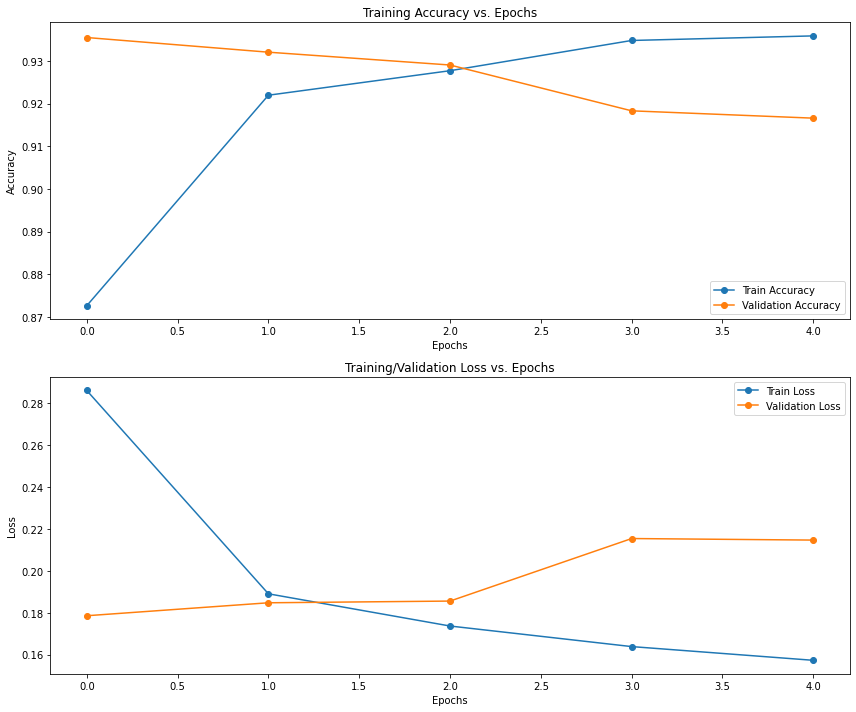

In [ ]:
perf_plot(history)

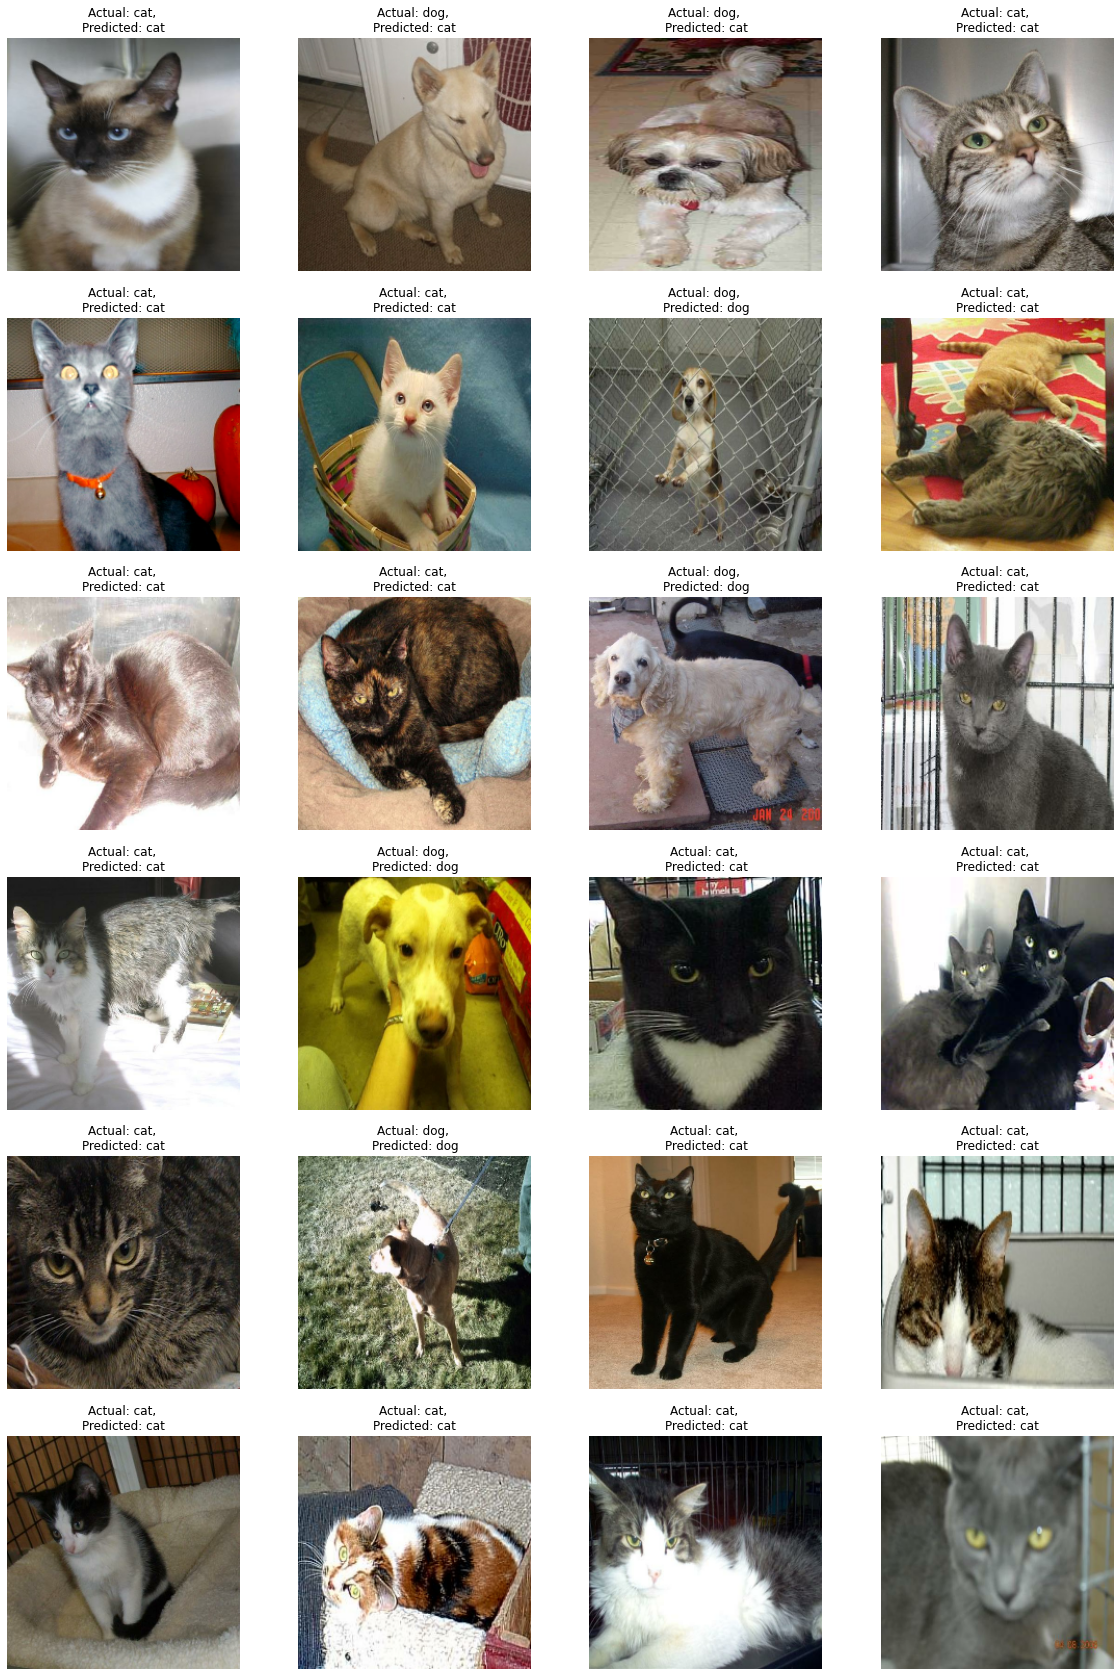

In [ ]:
# predicted result

prediction(model, test_image)

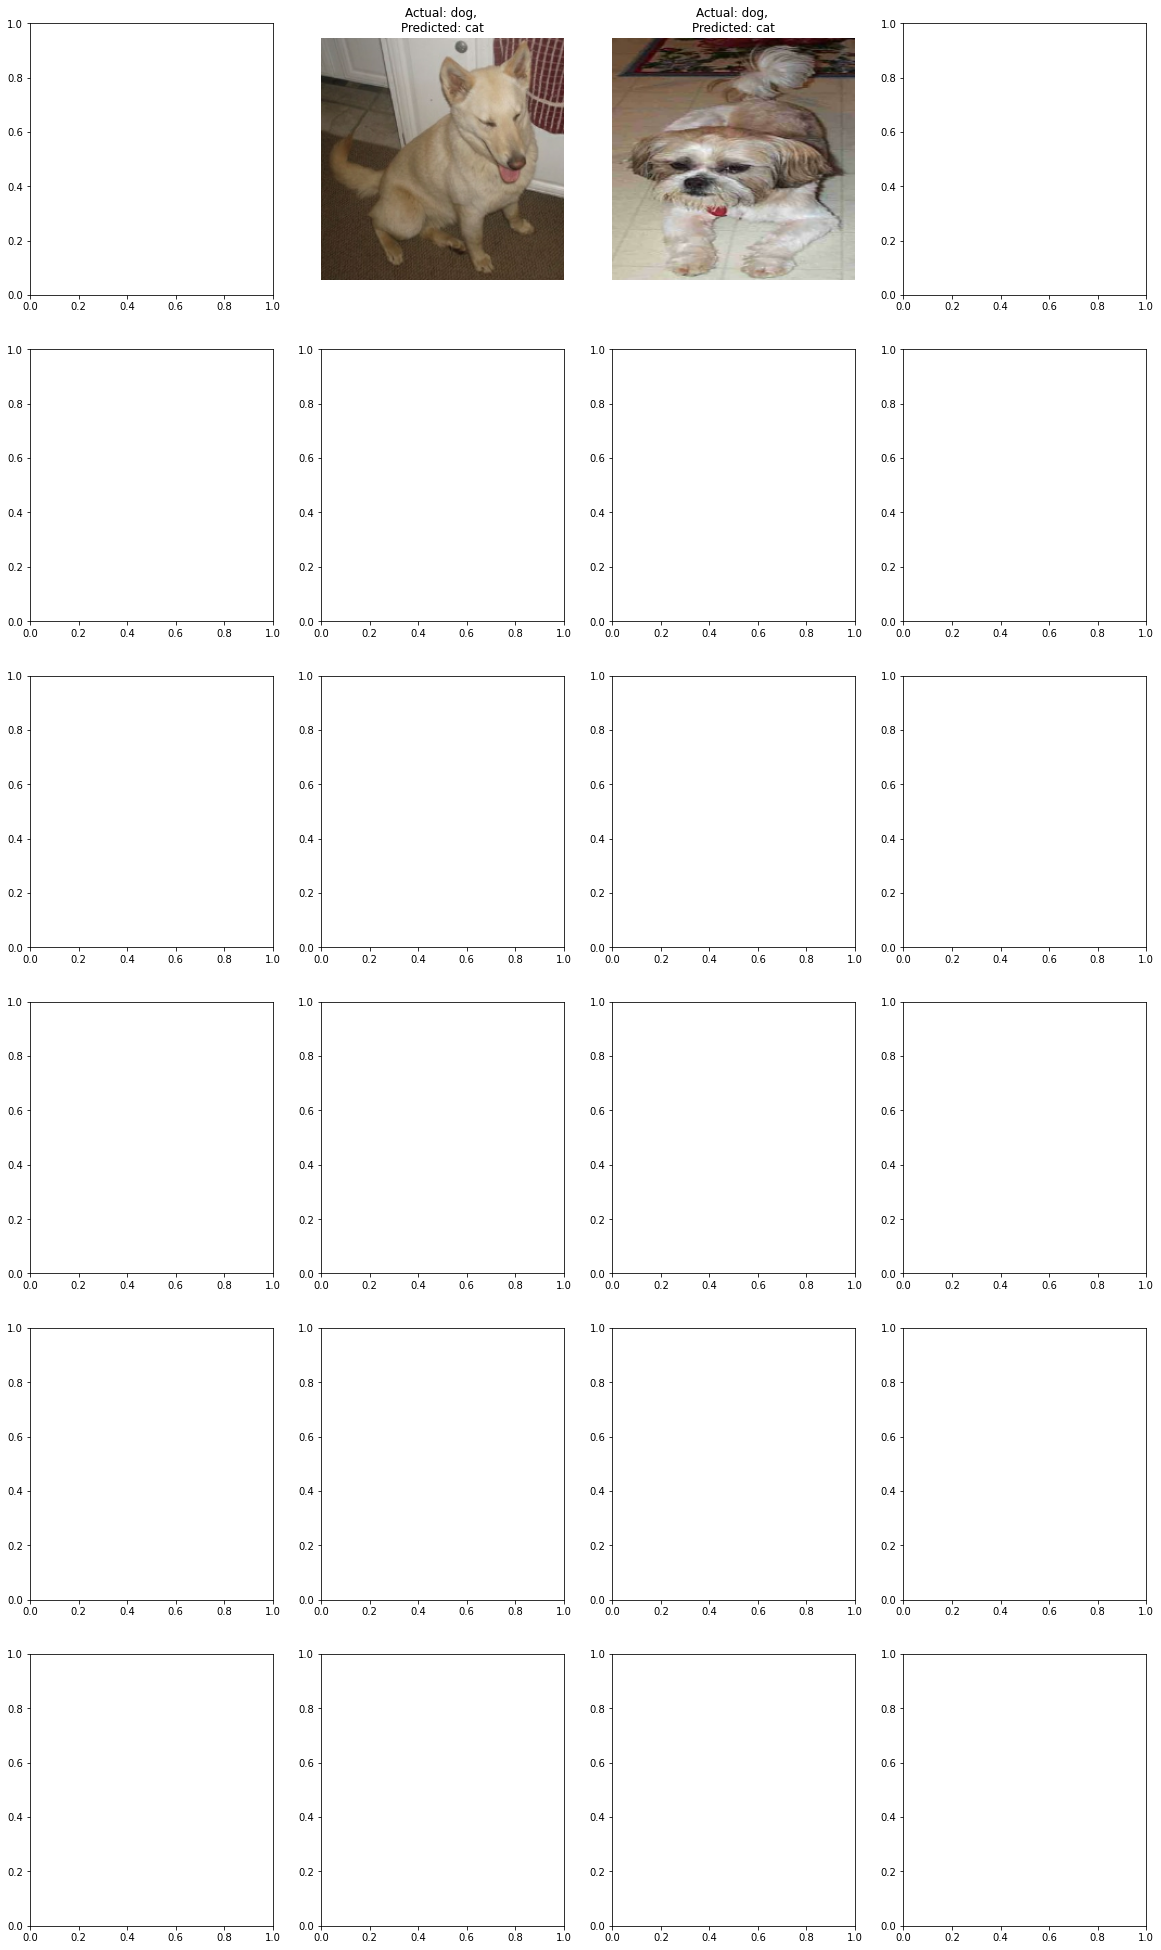

In [ ]:
#wrong prediction
wrong_prediction(model, test_image)